In [1]:
from rtmag.paper.load import load_input_label, MyModel

In [2]:
mm = MyModel("/home/mgjeon/space/workspace/base_important/uno_pi_cc_hnorm_unit_aug/model_75.pt")

Model loaded from epoch 75


In [3]:
input_files, label_files = load_input_label("/mnt/f/isee_dataset/11158")
len(input_files), len(label_files)

(66, 66)

In [4]:
idx = 13
input_files[idx]

PosixPath('/mnt/f/isee_dataset/11158/input/input_11158_20110214_000000.npz')

In [5]:
from time import time

In [6]:
start_time = time()
b = mm.get_pred(input_files[idx])
print(f"{time() - start_time} seconds")

0.8057551383972168 seconds


In [7]:
start_time = time()
B = mm.get_label(label_files[idx])
dx, dy, dz, dV = mm.get_dV(input_files[idx])
print(f"{time() - start_time} seconds")

1.470870018005371 seconds


In [8]:
b.shape, B.shape

((512, 256, 256, 3), (512, 256, 256, 3))

In [9]:
import numpy as np

In [10]:
Lx = b.shape[0]
Ly = b.shape[1]

numbers = 20

# xmin, xmax, ymin, ymax
xyranges = [
    [0.30, 0.35, 0.50, 0.55],
    [0.45, 0.50, 0.60, 0.65],
    [0.65, 0.70, 0.70, 0.80],
    [0.35, 0.40, 0.30, 0.35],
    [0.35, 0.40, 0.40, 0.45],
    [0.30, 0.35, 0.30, 0.35],
    [0.70, 0.75, 0.70, 0.75],
    [0.32, 0.35, 0.40, 0.45],
]

seeds_xs = []

for xyrange in xyranges:

    xrange = np.array(xyrange[:2]) * Lx
    yrange = np.array(xyrange[2:]) * Ly

    np.random.seed(0)
    seeds = np.random.rand(numbers, 3) * [1, 1, 0]
    # seeds = np.stack([np.linspace(0, 1, numbers), np.linspace(0, 1, numbers), np.linspace(0, 1, numbers)], axis=-1) * [1, 1, 0]
    seeds[:, 0] = seeds[:, 0] * (xrange[1] - xrange[0]) + xrange[0]
    seeds[:, 1] = seeds[:, 1] * (yrange[1] - yrange[0]) + yrange[0]
    seeds_xs.append(seeds)

seeds_xs = np.vstack(seeds_xs)

In [11]:
seeds_xs.shape

(160, 3)

In [12]:
import pyvista as pv

from rtmag.paper.metric import current_density, curl

In [13]:
def create_coordinates(bounds):
    xbounds = (bounds[0], bounds[1])
    ybounds = (bounds[2], bounds[3])
    zbounds = (bounds[4], bounds[5])
    meshgrid = np.mgrid[xbounds[0]:xbounds[1]+1, ybounds[0]:ybounds[1]+1, zbounds[0]:zbounds[1]+1]
    return np.stack(meshgrid, axis=-1).astype(np.float32)

def create_mesh(b):
    bx, by, bz = b[..., 0], b[..., 1], b[..., 2]
    bx, by, bz = map(np.array, (bx, by, bz))
    Nx, Ny, Nz = bx.shape
    co_bounds = (0, Nx-1, 0, Ny-1, 0, Nz-1)
    co_coords = create_coordinates(co_bounds).reshape(-1, 3)
    co_coord = co_coords.reshape(Nx, Ny, Nz, 3)
    x = co_coord[..., 0]
    y = co_coord[..., 1]
    z = co_coord[..., 2]
    mesh = pv.StructuredGrid(x, y, z)
    vectors = np.stack([bx, by, bz], axis=-1).transpose(2, 1, 0, 3).reshape(-1, 3)
    mesh['vector'] = vectors
    mesh.active_vectors_name = 'vector'
    magnitude = np.linalg.norm(vectors, axis=-1)
    mesh['magnitude'] = magnitude
    mesh.active_scalars_name = 'magnitude'

    j = curl(b)
    j_vec = np.stack([j[..., 0], j[..., 1], j[..., 2]], axis=-1).transpose(2, 1, 0, 3).reshape(-1, 3)
    mesh['current'] = j_vec
    j_mag = np.linalg.norm(j_vec, axis=-1)
    mesh['current_magnitude'] = j_mag

    j = current_density(b, dx, dy, dz)
    j_vec = np.stack([j[..., 0], j[..., 1], j[..., 2]], axis=-1).transpose(2, 1, 0, 3).reshape(-1, 3)
    mesh['current_density'] = j_vec
    j_mag = np.linalg.norm(j_vec, axis=-1)
    mesh['current_density_magnitude'] = j_mag

    return mesh

In [14]:
mesh = create_mesh(b)

In [15]:
mesh_c = create_mesh(b[128:256, 64:256, 128:256])

In [16]:
p = pv.Plotter(window_size=(1000, 600))
p.add_mesh(mesh.outline())
seed = pv.PolyData(seeds_xs)
# p.add_mesh(seed, color='blue', point_size=3)
strl = mesh.streamlines_from_source(seed,
                                    vectors='vector',
                                    max_time=10000,
                                    initial_step_length=0.1,
                                    integration_direction='both')
x_ind_min, y_ind_min, z_ind_min = 0, 0, 0
Nx, Ny, Nz = mesh.dimensions
x_ind_max, y_ind_max, z_ind_max = Nx-1, Ny-1, Nz-1
bottom_subset = (x_ind_min, x_ind_max, y_ind_min, y_ind_max, 0, 0)
vmin, vmax = -2500, 2500
dargs_B = dict(
        scalars='vector', 
        component=2, 
        clim=(vmin, vmax), 
        scalar_bar_args=dict(
            title='Bz [G]',
            title_font_size=15,
            height=0.25,
            width=0.05,
            vertical=True,
            position_x = 0.05,
            position_y = 0.05,
        ),
        show_scalar_bar=False, 
        lighting=False
    )
bottom = mesh.extract_subset(bottom_subset).extract_surface()
p.add_mesh(strl.tube(radius=1), 
           cmap=pv.LookupTable(cmap='jet', scalar_range=(1, 5), log_scale=True), 
           scalars='current_density_magnitude',
           scalar_bar_args=dict(title="Current Density [mA/m^2]"))
p.add_mesh(bottom, cmap='gray', **dargs_B)
p.camera_position = "xy"
p.camera.zoom(1.3)
p.show(jupyter_backend="trame")

Widget(value='<iframe src="http://localhost:39713/index.html?ui=P_0x7f00145348e0_0&reconnect=auto" class="pyvi…

: 

In [17]:
Mesh = create_mesh(B)

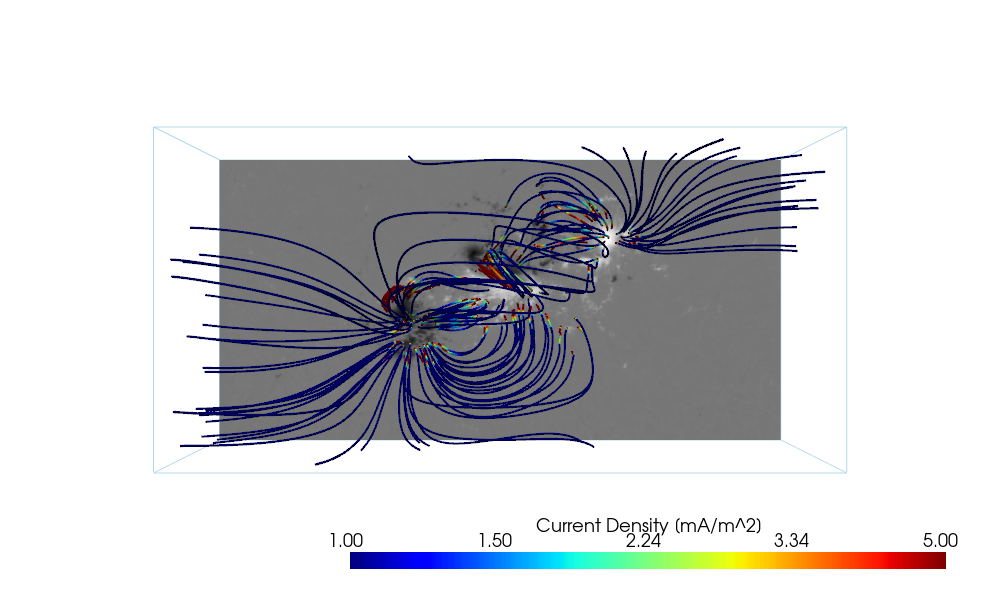

In [18]:
p = pv.Plotter(window_size=(1000, 600))
p.add_mesh(Mesh.outline())
seed = pv.PolyData(seeds_xs)
strl = Mesh.streamlines_from_source(seed,
                                    vectors='vector',
                                    max_time=10000,
                                    initial_step_length=0.1,
                                    integration_direction='both')
x_ind_min, y_ind_min, z_ind_min = 0, 0, 0
Nx, Ny, Nz = Mesh.dimensions
x_ind_max, y_ind_max, z_ind_max = Nx-1, Ny-1, Nz-1
bottom_subset = (x_ind_min, x_ind_max, y_ind_min, y_ind_max, 0, 0)
vmin, vmax = -2500, 2500
dargs_B = dict(
        scalars='vector', 
        component=2, 
        clim=(vmin, vmax), 
        scalar_bar_args=dict(
            title='Bz [G]',
            title_font_size=15,
            height=0.25,
            width=0.05,
            vertical=True,
            position_x = 0.05,
            position_y = 0.05,
        ), 
        show_scalar_bar=False, 
        lighting=False
    )
bottom = Mesh.extract_subset(bottom_subset).extract_surface()
p.add_mesh(strl.tube(radius=1), 
           cmap=pv.LookupTable(cmap='jet', scalar_range=(1, 5), log_scale=True), 
           scalars='current_density_magnitude',
           scalar_bar_args=dict(title="Current Density [mA/m^2]"))
p.add_mesh(bottom, cmap='gray', **dargs_B)
p.camera_position = "xy"
p.camera.zoom(1.3)
p.show(jupyter_backend="static")